In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import re
import string
import joblib
from nltk import corpus
from itertools import chain
import nltk
nltk.download('punkt')
nltk.download('universal_tagset')
nltk.download('stopwords')
nltk.download('wordnet')

sns.set_theme()

[nltk_data] Downloading package punkt to /home/smiga287/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/smiga287/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/smiga287/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/smiga287/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Exploratory data analysis

In [2]:
df = pd.read_csv('../dataset/train.csv')

In [3]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,15604,Web Application Developer (Node.JS),"US, OR, Portland",NaN,NaN,Can data be a thing of beauty? We think so.At ...,About Seabourne ConsultingCan data be a thing ...,Responsibilities:The Web Application Developer...,"Location: Portland, OR. You must reside in the...",1,1,1,Contract,Associate,NaN,Computer Software,Engineering,0
1,1946,Graduates: English Teacher Abroad (Conversatio...,"US, NY, Ithaca",NaN,NaN,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it :-)Love travel...",University degree required. TEFL / TESOL / CEL...,See job description,0,1,1,Contract,Entry level,Bachelor's Degree,Education Management,Education,0
2,7513,English Teacher Abroad (Conversational),"US, CA, Chico",NaN,NaN,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it.Vacancies in A...",University degree required. TEFL / TESOL / CEL...,See job description,0,1,1,Contract,NaN,Bachelor's Degree,Education Management,Education,0
3,17564,"URGENT Job Full Time & Part Time, Cash Pay.","US, CA, Los Angeles",NaN,NaN,NaN,"URGENT Job Full Time &amp; Part Time, Cash Pay...",No any experience required.,Perfect for everyone then start immediately.,0,0,0,Part-time,NaN,NaN,NaN,NaN,1
4,8498,Android Developer,"DE, BE, Berlin",Development,NaN,NaN,Contentful (#URL_0252efddcbc4b8f51969fca7b0545...,You dream in Java and you’re proficient in And...,The Web is changing and becoming more interact...,0,1,1,Full-time,Mid-Senior level,NaN,Internet,Engineering,0


In [4]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,11979.000000,11979.000000,11979.000000,11979.000000,11979.000000
mean,8918.850405,0.041656,0.794891,0.492863,0.048418
std,5167.183017,0.199811,0.403798,0.499970,0.214657
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4449.500000,0.000000,1.000000,0.000000,0.000000
50%,8903.000000,0.000000,1.000000,0.000000,0.000000
75%,13410.500000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11979 entries, 0 to 11978
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               11979 non-null  int64 
 1   title                11979 non-null  object
 2   location             11748 non-null  object
 3   department           4264 non-null   object
 4   salary_range         1918 non-null   object
 5   company_profile      9749 non-null   object
 6   description          11978 non-null  object
 7   requirements         10187 non-null  object
 8   benefits             7118 non-null   object
 9   telecommuting        11979 non-null  int64 
 10  has_company_logo     11979 non-null  int64 
 11  has_questions        11979 non-null  int64 
 12  employment_type      9685 non-null   object
 13  required_experience  7254 non-null   object
 14  required_education   6561 non-null   object
 15  industry             8732 non-null   object
 16  func

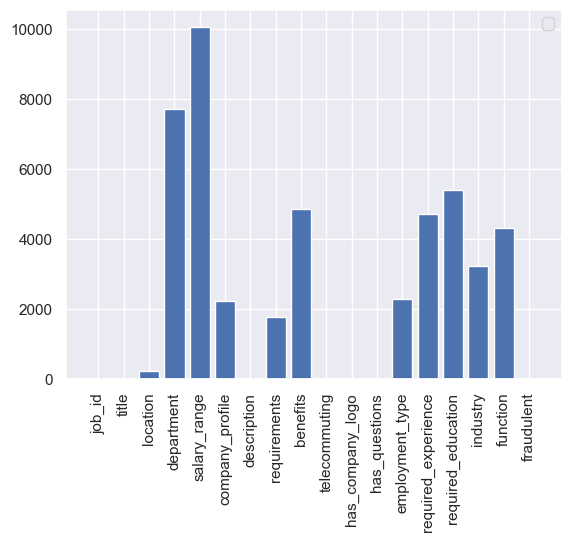

In [6]:
is_null = df.isna().sum()
plt.legend(is_null.index)
plt.xticks(rotation=90)
plt.bar(is_null.index, is_null.values)
plt.savefig('missing_vals_bar.png')

In [7]:
is_null.sort_values()[::-1]

salary_range           10061
department              7715
required_education      5418
benefits                4861
required_experience     4725
function                4323
industry                3247
employment_type         2294
company_profile         2230
requirements            1792
location                 231
description                1
title                      0
fraudulent                 0
telecommuting              0
has_company_logo           0
has_questions              0
job_id                     0
dtype: int64

Real count: 11399 i.e. 95.1582%
Fake count:   580 i.e. 4.8418%


<Axes: xlabel='fraudulent', ylabel='count'>

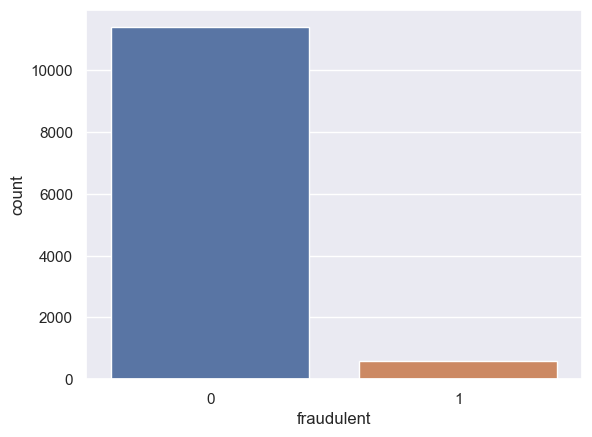

In [8]:
real_count, fake_count = df.fraudulent.value_counts()
N = df.shape[0]

print(f'Real count: {real_count:5} i.e. {real_count / N * 100:.4f}%')
print(f'Fake count: {fake_count:5} i.e. {fake_count / N * 100:.4f}%')

sns.countplot(x=df['fraudulent'])

count    11979.000000
mean         3.907672
std          2.152825
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         30.000000
Name: title, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x7f5e1416d950>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5e1416f150>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5e14143450>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5e141787d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f5e12d75f50>],
 'means': []}

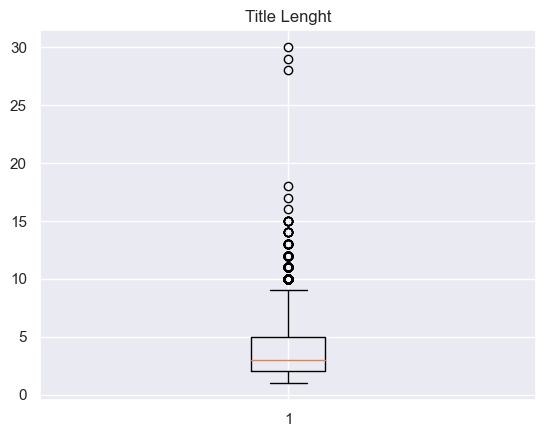

In [9]:
title_len = df.title.apply(lambda t: len(t.split(' ')))
plt.title('Title Lenght')
print(title_len.describe())
plt.boxplot(title_len)

In [3]:
country_list = pd.read_csv('../dataset/country_list.csv')
country_list.rename(columns={'Name': 'country', 'Code': 'country_code'}, inplace=True)
country_list.head()

,country,country_code
0,Afghanistan,AF
1,Åland Islands,AX
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS


In [4]:
# will be needed both for EDA and preprocessing 
def expand_location_info(df, country_list):
    location = df.location.str.split(',', n=2, expand=True)
    location.rename(columns={0: "country_code", 1: "state_code", 2: "city"}, inplace=True)
    
    df['country_code'] = location['country_code'].str.strip()
    df['state_code'] = location['state_code'].str.strip()
    df['city'] = location['city'].str.strip()

    del df['location']

    df = pd.merge(df, country_list, on='country_code', how='left')
    df.drop('country_code', axis=1, inplace=True)
    
    df.loc[df['country'] == '', 'country'] = 'NONE'
    df.loc[df['state_code'] == '', 'state_code'] = 'NONE'
    df.loc[df['city'] == '', 'city'] = 'NONE'

    return df

In [12]:
df = expand_location_info(df, country_list)

In [13]:
df[['city', 'state_code', 'country']].sample(5)

,city,state_code,country
9831,Toronto,ON,Canada
8378,San Diego,CA,United States
2643,Carlsbad,CA,United States
4833,Houston,TX,United States
6026,Peoria,IL,United States


In [14]:
jobs_by_country = df.groupby('country').size().sort_values(ascending=False)

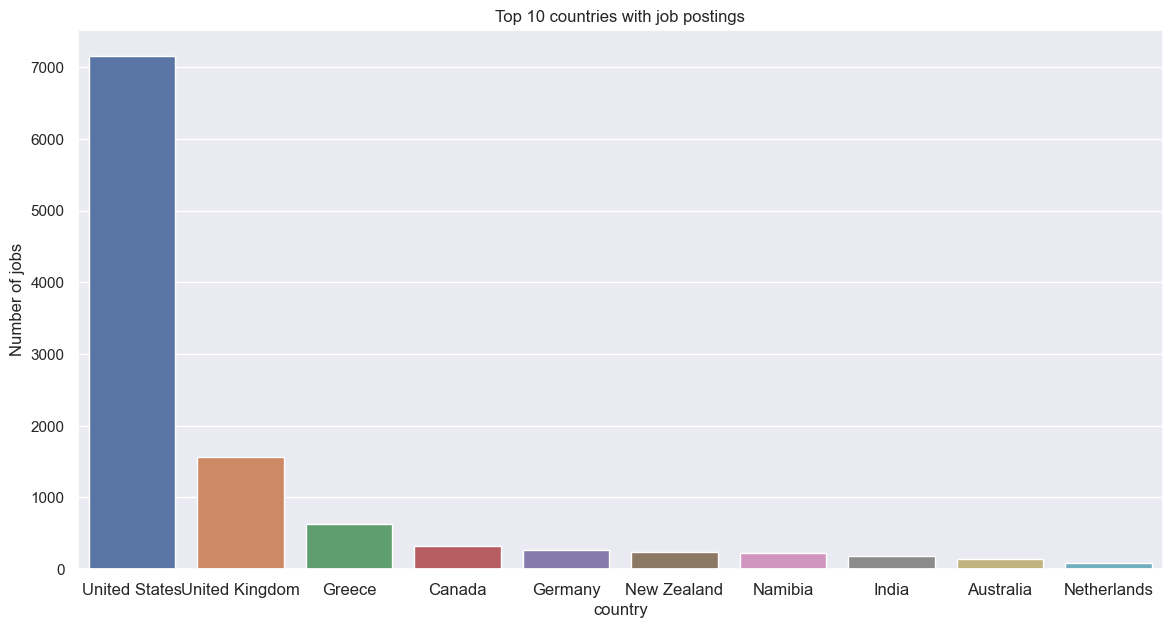

In [15]:
plt.figure(figsize=(14,7))
plt.title('Top 10 countries with job postings')
sns.barplot(x=jobs_by_country.head(10).index, y=jobs_by_country.head(10));
plt.xticks(fontsize=12)
plt.ylabel('Number of jobs');
plt.savefig('country_total_bar.png')

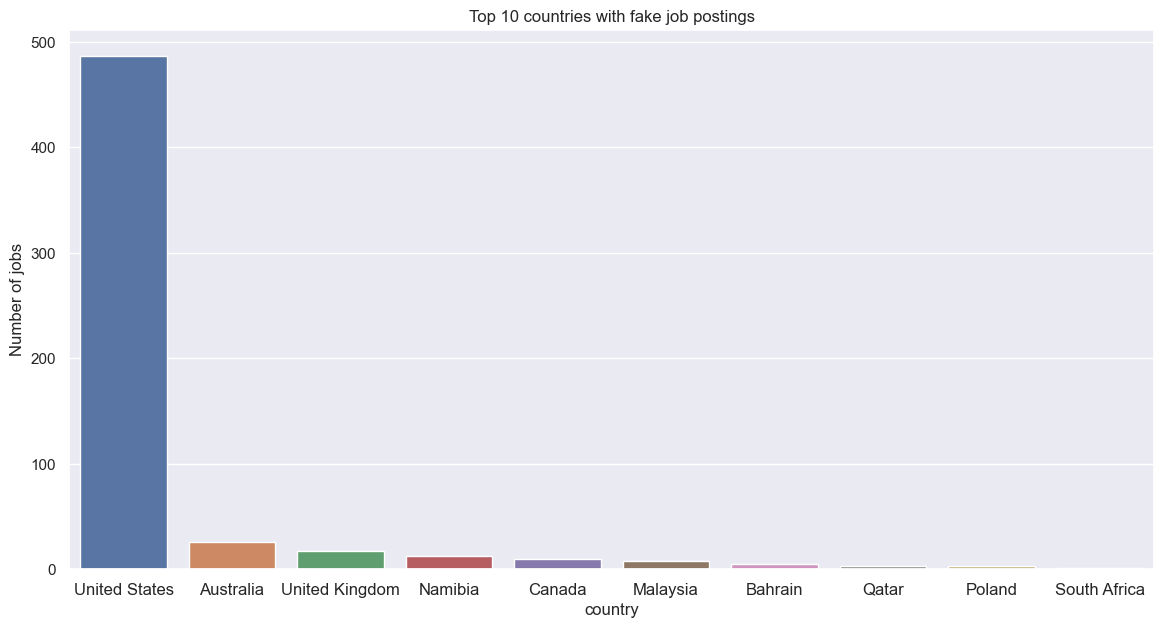

In [16]:
fake_jobs_by_country = df.groupby('country')[['fraudulent']].sum().sort_values('fraudulent', ascending=False)
plt.figure(figsize=(14,7))
plt.title('Top 10 countries with fake job postings')
sns.barplot(x=fake_jobs_by_country.head(10).index, y=fake_jobs_by_country.head(10).fraudulent);
plt.xticks(fontsize=12)
plt.ylabel('Number of jobs');
plt.savefig('country_fake_bar.png')

In [17]:
fake_jobs_per_state = df.groupby('state_code')[['fraudulent']].sum().sort_values('fraudulent', ascending=False)
top4_fake_jobs_by_state = fake_jobs_per_state.head(4)
rest = fake_jobs_per_state.iloc[4:, :].fraudulent.sum()
fake_jobs_per_state = pd.concat([top4_fake_jobs_by_state, pd.DataFrame({ 'fraudulent': [rest]}).set_index(pd.Index(['REST']))])

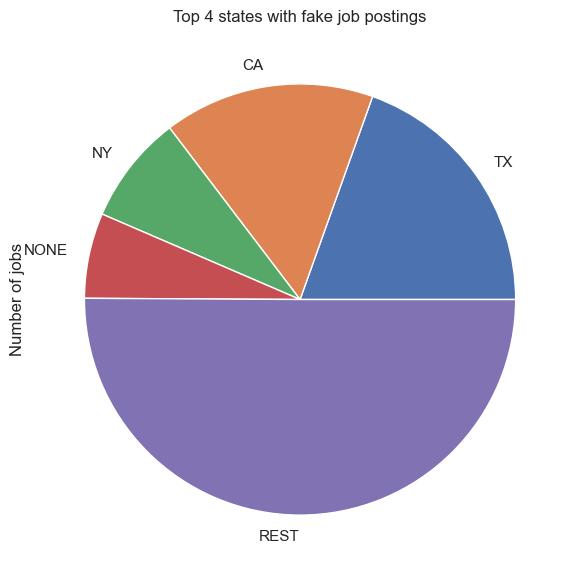

In [18]:
plt.figure(figsize=(14,7))
plt.title('Top 4 states with fake job postings')
plt.pie(x=fake_jobs_per_state.fraudulent, labels=fake_jobs_per_state.index)
plt.xticks(fontsize=12)
plt.ylabel('Number of jobs');
plt.savefig('state_fake_bar.png')

In [19]:
fake_jobs_per_state

,fraudulent
TX,110
CA,89
NY,46
NONE,36
REST,282


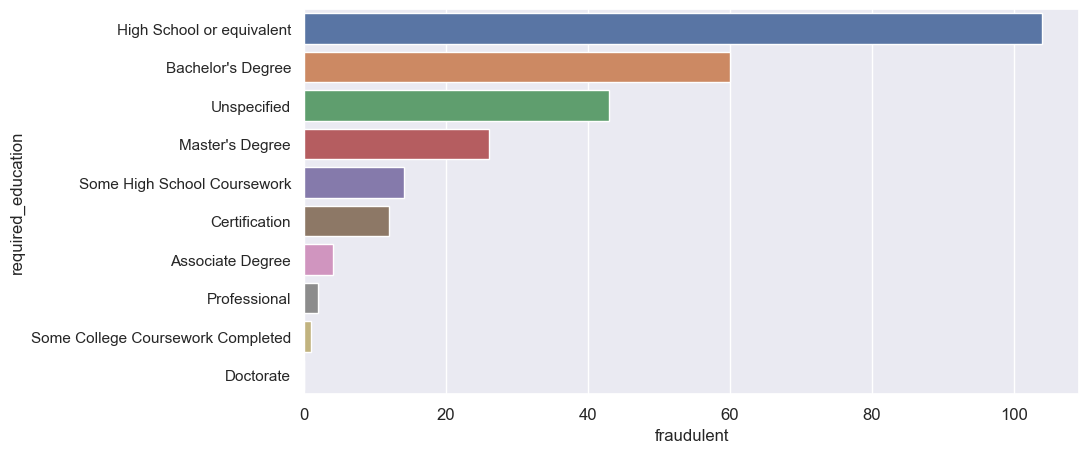

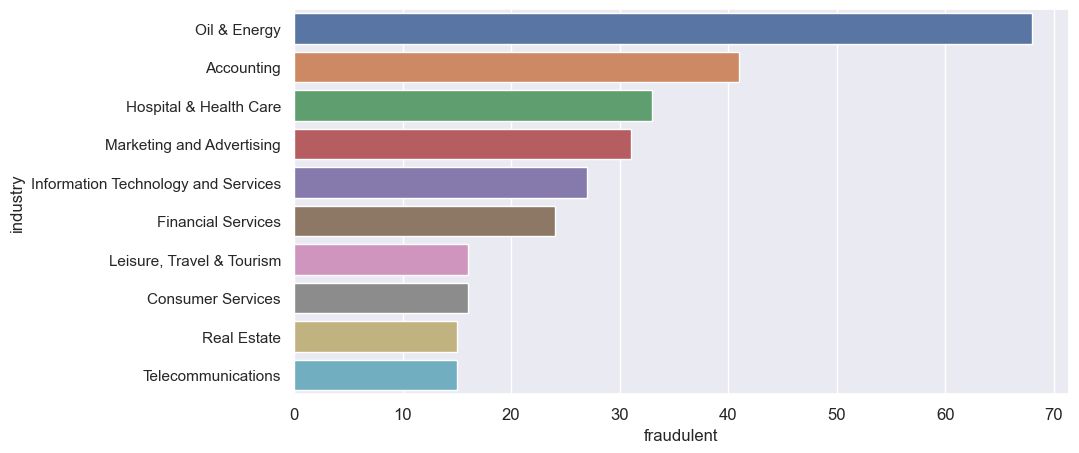

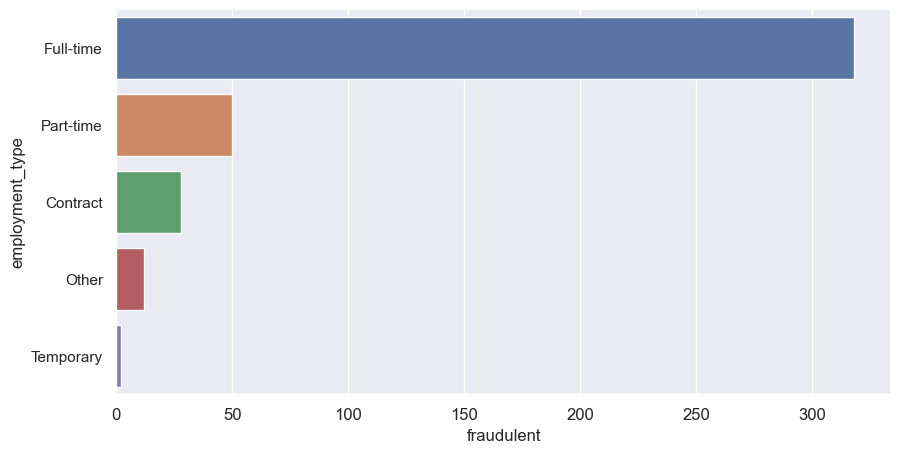

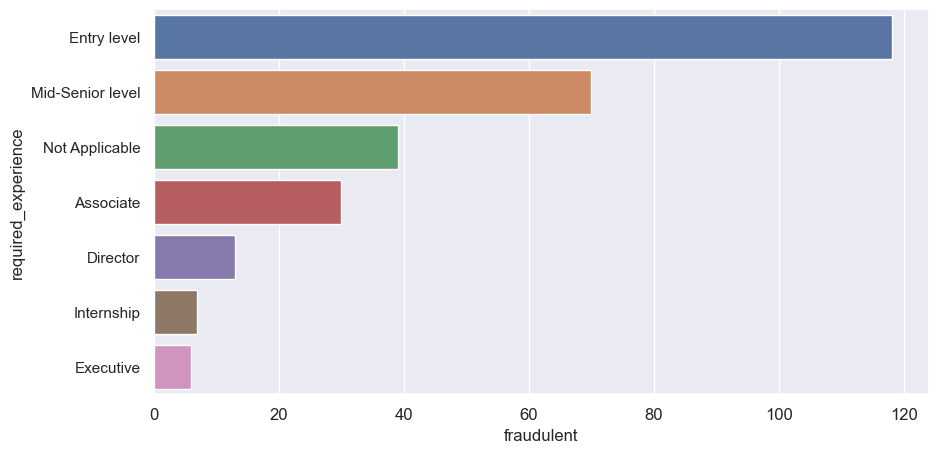

In [20]:
interesting_columns = ['required_education', 'industry', 'employment_type', 'required_experience']
for col in interesting_columns:
    fake_jobs_group = df.groupby(col)[['fraudulent']].sum().sort_values('fraudulent', ascending=False).head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(y=fake_jobs_group.index, x=fake_jobs_group.fraudulent);
    plt.xticks(fontsize=12)

## Preprocessing

In [25]:
df = pd.read_csv(f'../dataset/train.csv')

In [5]:
def flatten(lst): # equivalent to Haskell join                                                                                                   
    return list(chain.from_iterable(lst))

lemmatizer = nltk.stem.WordNetLemmatizer()
custom_stop_words = list(set(corpus.stopwords.words('english')) | set(('http', 'https')))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    sentences = nltk.tokenize.sent_tokenize(text)
    tokens = flatten([nltk.tokenize.word_tokenize(sentence) for sentence in sentences])
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [token for token in tokens if 30 > len(token) > 2]
    return ' '.join(tokens)

def preprocess_columns(df):
    # job_id is useless
    df.drop('job_id', inplace=True, axis=1)
    df = expand_location_info(df, country_list)
    
    columns_to_fill = pd.Index(['department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_experience','required_education', 'industry', 'function', 'country', 'state_code', 'city'])
    for column in columns_to_fill:
        df[column].fillna('', inplace=True)

    assert df[columns_to_fill].isna().sum().eq(0).all()

    columns_to_concat = columns_to_fill.insert(0, pd.Index(['title']))

    df['text'] = ''
    for col in columns_to_concat:
        df['text'] += ' ' + df[col]

    df.drop(columns_to_concat, axis=1, inplace=True)
    return df
    
def preprocess(df):
    df = preprocess_columns(df)
    df['text'] = df.text.apply(preprocess_text)
    return df

## Preparing for classification

In [27]:
df = preprocess(df)

In [28]:
df

,telecommuting,has_company_logo,has_questions,fraudulent,text
0,1,1,1,0,web application developer node can data thing ...
1,0,1,1,0,graduate english teacher abroad conversational...
2,0,1,1,0,english teacher abroad conversational help tea...
3,0,0,0,1,urgent job full time part time cash pay urgent...
4,0,1,1,0,android developer development contentful url a...
...,...,...,...,...,...
11974,0,1,1,0,sale manager sale company website url advisor ...
11975,0,0,1,0,security presales engineer service the primary...
11976,0,1,1,0,developer tizu free iphone app that allows you...
11977,0,1,0,0,database researcher 20000 20000 with over 300 ...


In [29]:
# NLTK's stopwords are used because of the following paper: https://aclanthology.org/W18-2502/
tf_idf_vectorizer = TfidfVectorizer(
    lowercase=True, 
    analyzer='word', 
    ngram_range=(1, 1),
    stop_words=custom_stop_words,
    max_features=10000, # TODOOOO
)

In [30]:
tf_idf_matrix = tf_idf_vectorizer.fit_transform(df['text'])

In [31]:
column_names = [f'word_{feature}' for feature in tf_idf_vectorizer.get_feature_names_out()]
df = pd.concat([df, pd.DataFrame(tf_idf_matrix.toarray(), columns=column_names)], axis=1)
df.drop('text', axis=1, inplace=True)

df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,word_000,word_0001pt,word_00am,word_00pm,word_0400,word_0cm,...,word_του,word_τους,word_των,word_υλοποίηση,word_υπηρεσίες,word_υπηρεσιών,word_χρόνια,word_χώρο,word_όπως,word_ότι
0,1,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
dump = lambda df, is_train: joblib.dump(df, f'../dataset/{"train" if is_train else "test"}_preprocessed_classification.joblib')

In [33]:
dump(df, is_train=True)

['../dataset/train_preprocessed_classification.joblib']

In [34]:
test_df = pd.read_csv(f'../dataset/test.csv')

In [35]:
test_df = preprocess(test_df)
test_df

,telecommuting,has_company_logo,has_questions,fraudulent,text
0,0,1,0,0,marketing representative tidewater finance est...
1,0,0,0,1,casual job immediate start looking for work ar...
2,0,1,1,0,office manager professional multi tasker 40000...
3,0,1,0,0,sale partner mission statement are community r...
4,0,1,1,0,senior java developer hello worldtalents23 dri...
...,...,...,...,...,...
5896,0,1,1,0,sport coach teacher 52000 78000 place highly q...
5897,0,1,1,0,account manager account handling 25000 27000 m...
5898,0,1,0,0,excellent opportunity available now our client...
5899,0,0,0,0,application developer provide full time perman...


In [36]:
tfidf_test_matrix = tf_idf_vectorizer.transform(test_df['text'])

test_df = pd.concat([test_df, pd.DataFrame(tfidf_test_matrix.toarray(), columns=column_names)], axis=1)
test_df.drop('text', axis=1, inplace=True)

test_df

,telecommuting,has_company_logo,has_questions,fraudulent,word_000,word_0001pt,word_00am,word_00pm,word_0400,word_0cm,...,word_του,word_τους,word_των,word_υλοποίηση,word_υπηρεσίες,word_υπηρεσιών,word_χρόνια,word_χώρο,word_όπως,word_ότι
0,0,1,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,1,0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,1,0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5896,0,1,1,0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5897,0,1,1,0,0.111290,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5898,0,1,0,0,0.201158,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5899,0,0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
dump(test_df, is_train=False)

['../dataset/test_preprocessed_classification.joblib']

## Preparing for clustering

In [13]:
def preprocess_clustering(df):
    df = preprocess(df)
    return df

In [14]:
train_df = preprocess_clustering(pd.read_csv(f'../dataset/train.csv'))
test_df = preprocess_clustering(pd.read_csv(f'../dataset/test.csv'))

In [15]:
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
df.sample(5)

,telecommuting,has_company_logo,has_questions,fraudulent,text
7737,1,1,0,0,sale representative sale 25000 50000 envision ...
6606,0,1,0,0,outside sale professional macomb abc supply in...
8994,0,1,0,0,content writer intern fusemachines combine the...
10438,0,1,1,0,english teacher abroad help teacher get safe a...
13840,0,1,0,0,account receivable clerk 40000 45000 talentsph...


In [16]:
tf_idf_vectorizer = TfidfVectorizer(
    lowercase=True, 
    analyzer='word', 
    ngram_range=(1, 1),
    stop_words=custom_stop_words,
    max_features=10000,
)

In [17]:
X_tfidf = tf_idf_vectorizer.fit_transform(df['text'])

In [18]:
X_tfidf.shape

(17880, 10000)

In [19]:
lsa = make_pipeline(TruncatedSVD(n_components=2), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Explained variance of the SVD step: 4.0%


In [20]:
X_lsa.shape

(17880, 2)

In [21]:
joblib.dump(X_lsa, '../dataset/preprocessed_clustering.joblib')

['../dataset/preprocessed_clustering.joblib']

## Preparing for association rules

In [29]:
def preprocess_apriori(df):
    _, sample_df = train_test_split(df, test_size=0.33, stratify=df['fraudulent'], random_state=13)
    df = preprocess(sample_df)
    tf_idf_vectorizer = TfidfVectorizer(
        lowercase=True, 
        analyzer='word', 
        ngram_range=(1, 1),
        stop_words=custom_stop_words,
        max_features=2000,
    )

    X_tfidf = tf_idf_vectorizer.fit_transform(df.text)
    binary_matrix = np.where(X_tfidf.toarray() > 0, 1, 0)
    apriori_data = pd.DataFrame(binary_matrix, columns=tf_idf_vectorizer.get_feature_names_out())
    return apriori_data

In [30]:
train_df = pd.read_csv(f'../dataset/train.csv')
test_df = pd.read_csv(f'../dataset/test.csv')
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [31]:
apriori_data = preprocess_apriori(df)

In [32]:
apriori_data.shape

(5901, 2000)

In [33]:
apriori_data.to_csv('../dataset/apriori.csv', index=False)